In [14]:
import pandas as pd
from tqdm.notebook import tnrange, tqdm
import torch
import torchvision
from torch.utils.data import Dataset, TensorDataset
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [19]:
local_path='./state-farm-distracted-driver-detection_old/driver_imgs_list.csv'
kaggle_path='../input/state-farm-distracted-driver-detection/driver_imgs_list.csv'
df=pd.read_csv(local_path)
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subject    22424 non-null  object
 1   classname  22424 non-null  object
 2   img        22424 non-null  object
dtypes: object(3)
memory usage: 525.7+ KB
None


,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg
...,...,...,...
22419,p081,c9,img_56936.jpg
22420,p081,c9,img_46218.jpg
22421,p081,c9,img_25946.jpg
22422,p081,c9,img_67850.jpg


In [20]:
print(df["classname"].value_counts())

c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: classname, dtype: int64


In [21]:
def balance_df(df, cls):
    max_size = df[cls].value_counts().max()
    lst = [df]
    for class_index, group in df.groupby(cls):
        lst.append(group.sample(max_size-len(group), replace=True))
    frame_new = pd.concat(lst)
    df2=frame_new
    df3=df2.sample(frac=1) # randomise
    return(df3)

df = balance_df(df, 'classname')

In [22]:
df["classname"].value_counts()

c2    2489
c4    2489
c0    2489
c9    2489
c5    2489
c3    2489
c7    2489
c8    2489
c1    2489
c6    2489
Name: classname, dtype: int64

In [23]:
df.to_csv('balanced.csv')

In [24]:
def image_to_nparray(path):
    i = plt.imread(path)    
    return(np.array(i))

In [27]:
class C_Dataset(Dataset):
    """custom"""

    def __init__(self, csv_file_path, root_dir, transform=None):
        
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.transform = transform
        self.root_dir = root_dir
        self.d = pd.read_csv(csv_file_path, header= None)[1:]
    

        
    def __getitem__(self, idx):
        
        smol_img_path = str(self.d.iloc[idx][3])
        class_name = str(self.d.iloc[idx][2])[-1] #only the number
        full_img_path = self.root_dir + '/' + 'c'+ class_name + '/' + smol_img_path
        img_arr = image_to_nparray(full_img_path)
        
        if self.transform is not None:
            img_arr = self.transform(img_arr)
        
        return torch.tensor(int(class_name)), img_arr    
        
    def __len__(self):
        return (len(self.d))

In [28]:
local_train_path='./state-farm-distracted-driver-detection_old/imgs/train'

kaggle_train_path='../input/state-farm-distracted-driver-detection/imgs/train'

data = C_Dataset('balanced.csv', 
               local_train_path,
                transform = transforms.Compose([
                                                transforms.ToPILImage(),
                                                transforms.Resize((150,150), interpolation=2),
                                                transforms.RandomRotation(10),
                                                transforms.ToTensor()
                                                ])
                )

print(len(data))

24890


In [30]:
train_set, val_set = torch.utils.data.random_split(data, [len(data)-2000, 2000])

torch.Size([10, 3, 150, 150])
torch.Size([10])
class tensor(9)


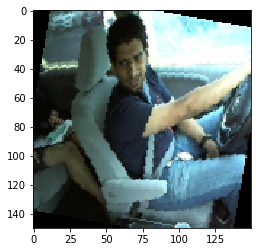

In [31]:
train_loader_1 = torch.utils.data.DataLoader(
    train_set
    ,batch_size=10
    ,shuffle=True
)

for labels,images in (train_loader_1):
            print(images.shape)
            print(labels.shape)
            print("class", labels[0])
            x=np.transpose(images[0], (1, 2, 0))            
            plt.imshow(x, interpolation='none')
            break
            
# c0: safe driving
# c1: texting - right
# c2: talking on the phone - right
# c3: texting - left
# c4: talking on the phone - left
# c5: operating the radio
# c6: drinking
# c7: reaching behind
# c8: hair and makeup
# c9: talking to passenger